In [ ]:
import sys
sys.path.append("../")

In [1]:
import re
from src.database.firebase_manager import get_firebase_data, connect_to_firebase
import seaborn as sns
import pandas as pd
import numpy as np
import folium

In [ ]:
connect_to_firebase()

In [23]:
data_perdiz = get_firebase_data("Perdizes, São Paulo")
data_consol = get_firebase_data("Consolação, São Paulo")
data_liberd = get_firebase_data("Liberdade, São Paulo")

df_perdiz = pd.DataFrame(data_perdiz)
df_perdiz["label"] = "Perdizes"
df_consol = pd.DataFrame(data_consol)
df_consol["label"] = "Consolação"
df_liberd = pd.DataFrame(data_liberd)
df_liberd["label"] = "Liberdade"

In [24]:
df = pd.concat([df_consol, df_perdiz, df_liberd], ignore_index = True)

In [25]:
def skip_nans(df):
    df.vagas.fillna("Não especificado", inplace=True)
    df.quartos.fillna("Não especificado", inplace=True)
    df["área"].fillna("Não especificado", inplace=True)
skip_nans(df)

In [26]:
first_sixth = np.quantile(df.preço, 1/6)
last_sixth = np.quantile(df.preço, 5/6)

# Criando nosso mapa
m = folium.Map(location=[-23.5558, -46.6396], zoom_start=13)

for lat,lon,preco,n_quartos,n_banheiros,n_vagas,area,link,img  in zip(df.lat, df.lon, df['preço'], df['quartos'], df['banheiros'], df['vagas'], df['área'], df.link, df.img1):
    if isinstance(n_vagas, float):
        n_vagas = int(n_vagas)
    html = f'''
    <img src="{img}" alt="Foto anúncio" style="width:100%;">
    <table id="vertical-1" class="centerTable">
      <tr>
        <th>Aluguel</th>
        <td>R$ {preco},00</td>
      </tr>
      <tr>
        <th>Quartos</th>
        <td>{n_quartos}</td>
      </tr>
      <tr>
        <th>Banheiros</th>
        <td>{n_banheiros}</td>
      </tr>
      <tr>
        <th>Vagas</th>
        <td>{n_vagas}</td>
      </tr>
      <tr>
        <th>Área</th>
        <td>{area} m²</td>
      </tr>
    </table>
    <div style="text-align:center">
        <a href="{link}">link</a>
    </div>'''
    iframe = folium.IFrame(html,
                       width=250,
                       height=400)
    popup = folium.Popup(iframe)
    if preco <= first_sixth:
        color="green"
    elif preco < last_sixth:
        color="orange"
    else:
        color="red"
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.Icon(icon="building", prefix="fa", color=color),
    ).add_to(m)

In [27]:
m

In [33]:
df.head()

,banheiros,distance,endereço,img1,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio,label
0,1,32.672460,"01415-001, Consolação, São Paulo, Estado de Sã...",https://img-us-1.trovit.com/img1br/1T01h01t0g1...,-23.552651,https://rd.clk.thribee.com/id.1T01h01t0g12/ori...,-46.655767,1550,1,trovit,"Apto, Consolação, 1 Quarto, 22 m2 - São Paulo\...",22,Não especificado,NaN,Consolação
1,1,32.665448,"01050-070, Consolação, São Paulo, Estado de Sã...",https://img-us-1.trovit.com/img1br/1d812X1K1p1...,-23.549042,https://rd.clk.thribee.com/id.1d812X1K1p121X/o...,-46.642241,1210,1,trovit,"Apto, Consolação, 1 Quarto, 30 m2 - São Paulo\...",30,Não especificado,NaN,Consolação
2,1,32.666679,"01306-001, Consolação, São Paulo, Estado de Sã...",https://img-us-1.trovit.com/img1br/1JM1C1q-ZL1...,-23.550563,https://rd.clk.thribee.com/id.1JM1C1q-ZL17/ori...,-46.645503,930,1,trovit,"Apto, Consolação, 1 Quarto, 17 m2 - São Paulo\...",17,Não especificado,NaN,Consolação
3,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",https://img-us-1.trovit.com/img1br/1M_g3P1S1fK...,-23.547308,https://rd.clk.thribee.com/id.1M_g3P1S1fK/orig...,-46.646067,2800,1,trovit,"Apto, Consolação, 1 Quarto, 34 m2 - São Paulo\...",34,Não especificado,NaN,Consolação
4,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",https://img-us-1.trovit.com/img1br/16s1U18i1w1...,-23.547308,https://rd.clk.thribee.com/id.16s1U18i1w1ng/or...,-46.646067,2000,2,trovit,"Apto, Consolação, 2 Quarto, 47 m2 - São Paulo\...",47,Não especificado,NaN,Consolação


<AxesSubplot:xlabel='preço', ylabel='Count'>

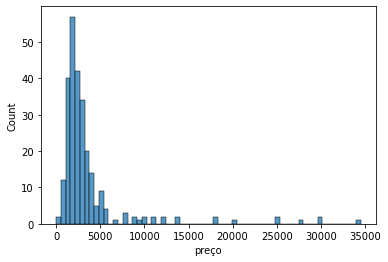

In [28]:
sns.histplot(df.preço)

<AxesSubplot:xlabel='preço', ylabel='Count'>

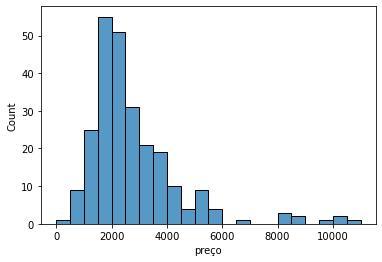

In [29]:
sns.histplot(df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500)

<AxesSubplot:xlabel='preço', ylabel='Count'>

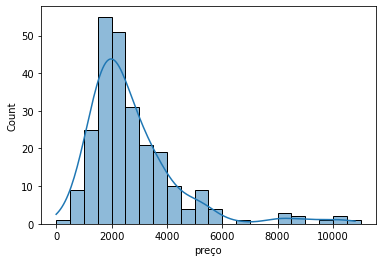

In [30]:
sns.histplot(df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500, kde=True)

<AxesSubplot:xlabel='preço', ylabel='Count'>

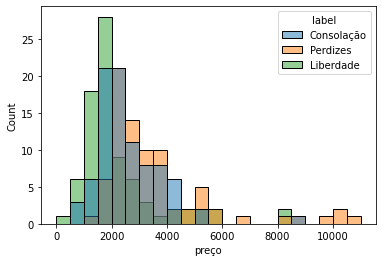

In [31]:
sns.histplot(data = df[df.preço < np.quantile(df.preço, 0.95)], x="preço", hue="label", binwidth=500)

<AxesSubplot:xlabel='preço', ylabel='Count'>

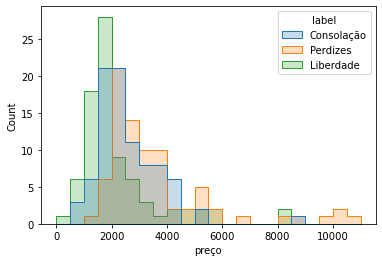

In [32]:
sns.histplot(data=df[df.preço < np.quantile(df.preço, 0.95)], x="preço", hue="label", element="step", binwidth=500)

<AxesSubplot:xlabel='área', ylabel='Count'>

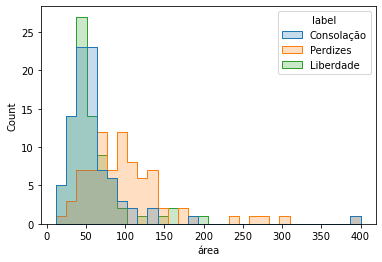

In [35]:
sns.histplot(data=df[df.preço < np.quantile(df.preço, 0.95)], x="área", hue="label", element="step")